# Run Perception

AVstack leverages `MMDetection` as its perception engine. With dozens of models across camera and LiDAR tasks, MMDetection can really accelerate the process of AV algorithm development.

In [1]:
import os
import avstack
import avapi

%load_ext autoreload
%autoreload 2

data_base = '../../lib-avstack-api/data/'
obj_data_dir_k = os.path.join(data_base, 'KITTI/object')
raw_data_dir_k = os.path.join(data_base, 'KITTI/raw')
data_dir_n     = os.path.join(data_base, 'nuScenes')
data_dir_c     = os.path.join(data_base, 'CARLA/ego-lidar')

KSM = avapi.kitti.KittiScenesManager(obj_data_dir_k, raw_data_dir_k, convert_raw=False)
NSM = avapi.nuscenes.nuScenesManager(data_dir_n)
CSM = avapi.carla.CarlaScenesManager(data_dir_c)

KDM = KSM.get_scene_dataset_by_name(scene_name="2011_09_26_drive_0005_sync")
NDM = NSM.get_scene_dataset_by_index(scene_idx=3)
CDM = CSM.get_scene_dataset_by_index(scene_idx=0)

DM = KDM  # let's use KITTI for this one

deallocate_models = True

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
frame = 120
img = DM.get_image(frame, sensor='main_camera')
pc = DM.get_lidar(frame, sensor='main_lidar')
objects_lidar = DM.get_objects(frame, sensor='main_lidar')
objects_camera = DM.get_objects(frame, sensor='main_camera')

## 3D Detection

### Inference

In [3]:
# lidar-based 3D detection
M_lidar_3d = avstack.modules.perception.object3d.MMDetObjectDetector3D(
    model='pointpillars', dataset='kitti', front_only=False, gpu=0, threshold=0.7)
objs_det_lid = M_lidar_3d(pc, frame=frame, identifier='lidar-detection')

Overriding default threshold of 0.5 with 0.7


/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/evaluation/functional/kitti_utils/eval.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_thresholds(scores: np.ndarray, num_gt, num_sample_pts=41):
/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:92: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth


/home/spencer/.cache/pypoetry/virtualenvs/avstack-docs-l0eE3ZqO-py3.10/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visualization

/home/spencer/.cache/pypoetry/virtualenvs/avstack-docs-l0eE3ZqO-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


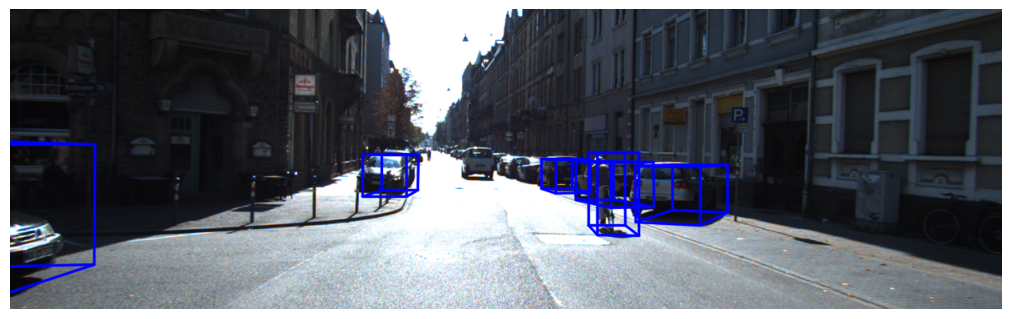

In [4]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_lid, box_colors='blue', inline=True)

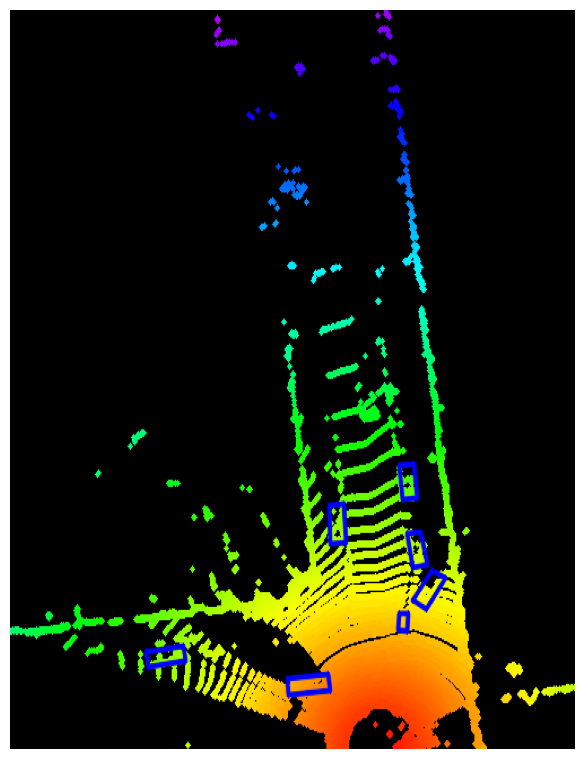

In [5]:
avapi.visualize.snapshot.show_lidar_bev_with_boxes(pc, boxes=objs_det_lid, box_colors='blue')

### Evaluation

In [6]:
# In this case, the "false positives" are just because KITTI
# doesn't label everything in the scene. The perception is solid.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_lid, truths=objects_lidar, metric='3D_IoU')

Result Manager
----7 detections, 5 truths
----0 detections are dontcares
----5 Assignments, 2 FPs, 0 FNs

## 2D Detection

### Inference

In [7]:
# camera-based 2D detection
M_camera_2d = avstack.modules.perception.object2dfv.MMDetObjectDetector2D(
    model='fasterrcnn', dataset='kitti', front_only=True, gpu=0, threshold=0.7)
objs_det_cam = M_camera_2d(img, frame=frame, identifier='camera-detection')

Overriding default threshold of 0.5 with 0.7
Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection/checkpoints/cityscapes/faster_rcnn_r50_fpn_1x_cityscapes_20200502-829424c0.pth


### Visualization

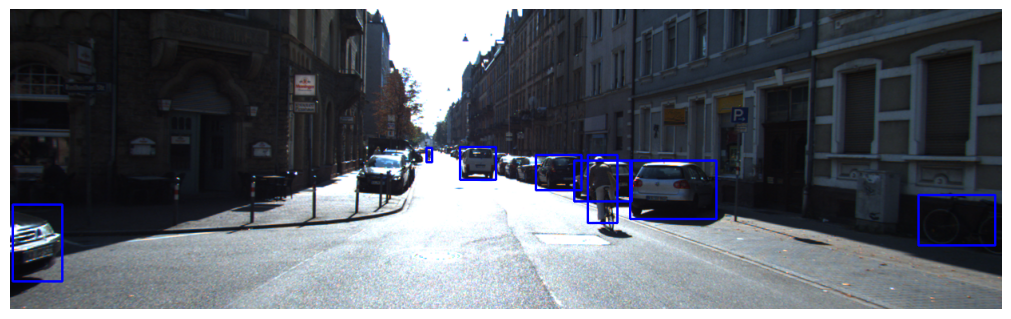

In [8]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_cam, box_colors='blue', inline=True)

### Evaluation

In [9]:
# Again, the "false positives" are just because KITTI
# doesn't label everything in the scene. The perception is solid.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_cam, truths=objects_camera, metric='2D_IoU')

Result Manager
----8 detections, 5 truths
----0 detections are dontcares
----4 Assignments, 4 FPs, 1 FNs

## Monocular Detection

### Inference

In [10]:
# camera-based 3D detection
M_camera_3d = avstack.modules.perception.object3d.MMDetObjectDetector3D(
    model='pgd', dataset='kitti', front_only=True, gpu=0, threshold=5)
objs_det_cam3d = M_camera_3d(img, frame=frame ,identifier='camera-detection')

Overriding default threshold of 5 with 5


/home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/mmdet3d/utils/setup_env.py:84: UserWarning: The current default scope "mmdet" is not "mmdet3d", `register_all_modules` will force the currentdefault scope to be "mmdet3d". If this is not expected, please set `init_default_scope=False`.
  warnings.warn('The current default scope '


Loads checkpoint by local backend from path: /home/spencer/Documents/Projects/AVstack/avstack-docs/lib-avstack-core/third_party/mmdetection3d/checkpoints/kitti/pgd_r101_caffe_fpn_gn-head_3x4_4x_kitti-mono3d_20211022_102608-8a97533b.pth
10/10 15:29:46 - mmengine - INFO - ModulatedDeformConvPack bbox_head.cls_convs.1.conv is upgraded to version 2.
10/10 15:29:46 - mmengine - INFO - ModulatedDeformConvPack bbox_head.reg_convs.1.conv is upgraded to version 2.


### Visualization

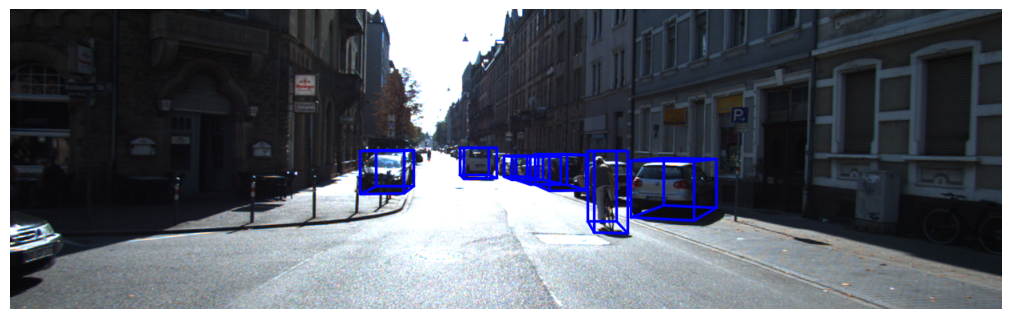

In [11]:
avapi.visualize.snapshot.show_image_with_boxes(img, objs_det_cam3d, box_colors='blue', inline=True)

### Evaluation

In [12]:
# Again, the "false positives" are just because KITTI
# doesn't label everything in the scene.
avapi.evaluation.ResultManager(idx=frame,
    detections=objs_det_cam3d, truths=objects_lidar, metric='3D_IoU')

Result Manager
----7 detections, 5 truths
----0 detections are dontcares
----3 Assignments, 4 FPs, 2 FNs